LSH Method

In [44]:
import numpy as np

# Example datasets for 1D, 2D, and 3D
X_1D = np.array([[1], [2], [3], [4], [5]])
X_2D = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4]])
X_3D = np.array([[1, 9, 3], [2, 3, 7], [4, 1, 5], [3, 7, 2], [5, 4, 8]])

query_pts_1D = np.array([[0], [7]])
query_pts_2D = np.array([[7, 4], [1, 7]])
query_pts_3D = np.array([[2, 9, 1], [4, 3, 7]])

def random_projections(X, query_pts, P):
    np.random.seed(35)
    R = np.random.randn(X.shape[1] + 1, P)  # +1 for the bias term
    X_proj = np.dot(np.hstack([X, np.ones((X.shape[0], 1))]), R)
    query_pts_proj = np.dot(np.hstack([query_pts, np.ones((query_pts.shape[0], 1))]), R)
    return X_proj, query_pts_proj, R

def pairwise_dist_naive(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.sum((x - y) ** 2))

def lsh_train(X, query_pts, P, K):
    # X_proj, query_pts_proj, R = random_projections(X, query_pts, P)

    return random_projections(X, query_pts, P)

def lsh_test(X, X_proj, query_pts_proj,K):
    # X_proj, query_pts_proj, R = random_projections(X, query_pts, P)
    
    results = []
    for query_pt_proj in query_pts_proj:
        query_region = np.sign(query_pt_proj)
        n = X_proj.shape[0]
        distances = []
        
        for i in range(n):
            if np.array_equal(np.sign(X_proj[i]), query_region):
                dist = pairwise_dist_naive(X_proj[i], query_pt_proj)
                distances.append((i, dist))
        
        # Sort distances based on the second element (distance) and pick top K
        distances.sort(key=lambda x: x[1])
        nearest_neighbors = [(X[idx], dist) for idx, dist in distances[:K]]
        results.append(nearest_neighbors)
    
    return results

# Test the function for 1D, 2D, and 3D
P = 3  # Number of projections
K = 2  # Number of nearest neighbors to find

for X, query_pts in [(X_1D, query_pts_1D), (X_2D, query_pts_2D), (X_3D, query_pts_3D)]:
    X_proj, query_pts_proj, R = lsh_train(X, query_pts, P, K)
    neighbors = lsh_test(X,X_proj, query_pts_proj,K)
    print("\nDimension:", X.shape[1])
    print("Query Point\tNearest Neighbors\tDistances")
    for query_pt, results in zip(query_pts, neighbors):
        if results:
            neighbors_str = ', '.join([f"{neighbor[0]} ({neighbor[1]:.6f})" for neighbor in results])
        else:
            neighbors_str = "No neighbors in the same region"
        print(f"{query_pt}\t{neighbors_str}")


print(neighbors)
# print(type(neighbors))



Dimension: 1
Query Point	Nearest Neighbors	Distances
[0]	(1,) (2.080615)
[7]	(5,) (4.161230), (4,) (6.241845)

Dimension: 2
Query Point	Nearest Neighbors	Distances
[7 4]	(5, 4) (4.161230), (4, 1) (10.078968)
[1 7]	(1, 9) (3.754138), (3, 7) (4.161230)

Dimension: 3
Query Point	Nearest Neighbors	Distances
[2 9 1]	(3, 7, 2) (4.927726), (1, 9, 3) (5.080653)
[4 3 7]	(4, 1, 5) (0.675591), (5, 4, 8) (1.948667)
[[((3, 7, 2), 4.927725655244311), ((1, 9, 3), 5.0806525260295725)], [((4, 1, 5), 0.6755910860826133), ((5, 4, 8), 1.9486665132653378)]]


KD Tree

In [45]:
from sklearn.neighbors import KDTree
import numpy as np


def kd_train(X):
    return KDTree(X, leaf_size=30)

def kd_test(X, query_pts, n_neighbors,kdtree):
    """
    X: numpy array of shape (n, d)
    query_pts: numpy array of shape (m, d), where m is the number of query points
    n_neighbors: int, number of neighbors to consider for each query point
    
    Returns the formatted output of the query point, nearest point(s), and distance(s)
    """
    kdtree = KDTree(X, leaf_size=30)  # Adjust the leaf_size based on your dataset
    distances, indices = kdtree.query(query_pts, k=n_neighbors)
    
    results = []
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        for j in range(n_neighbors):
            results.append({
                'Query Point': query_pts[i],
                'Nearest Point': X[idx[j]],
                'Distance': dist[j]
            })
    return results

# Example usage
X = np.array([[1, 9,1], [2, 3,4], [4, 1,2]])
query_pts = np.array([[7, 4,1], [1, 8,3]])  # Multiple query points
k = 2  # Number of neighbors to find
kdtree = kd_train(X)
results = kd_test(X, query_pts, k,kdtree)
for result in results:
    print("Query Point: {}, Nearest Point: {}, Distance: {:.2f}".format(
        result['Query Point'], result['Nearest Point'], result['Distance']
    ))


# Convert to the desired format
# print(results)
results_list = [(entry['Query Point'], entry['Distance']) for entry in results]

print(results_list)
# print(type(results_list))

Query Point: [7 4 1], Nearest Point: [4 1 2], Distance: 4.36
Query Point: [7 4 1], Nearest Point: [2 3 4], Distance: 5.92
Query Point: [1 8 3], Nearest Point: [1 9 1], Distance: 2.24
Query Point: [1 8 3], Nearest Point: [2 3 4], Distance: 5.20
[(array([7, 4, 1]), 4.358898943540674), (array([7, 4, 1]), 5.916079783099616), (array([1, 8, 3]), 2.23606797749979), (array([1, 8, 3]), 5.196152422706632)]


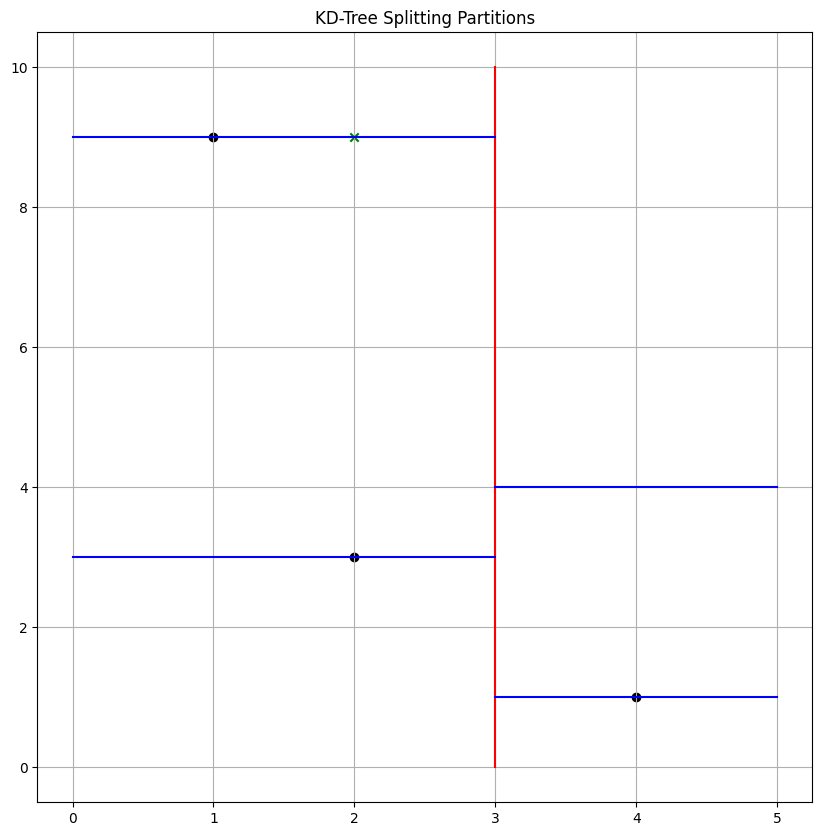

In [46]:
import numpy as np

# X = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])
# query_pt = np.array([7, 4])

query_pt =query_pts_3D[0]

class KDNode:
    def __init__(self, point, left=None, right=None):
        self.point = point
        self.left = left
        self.right = right

def build_kdtree(points, depth=0):
    n = len(points)
    if n == 0:
        return None

    k = len(points[0])  # assumes all points have the same dimension
    axis = depth % k

    # Sort point array and choose median as pivot element
    sorted_points = sorted(points, key=lambda point: point[axis])
    median_index = n // 2

    # Create node and recursively construct subtrees
    return KDNode(
        point=sorted_points[median_index],
        left=build_kdtree(sorted_points[:median_index], depth + 1),
        right=build_kdtree(sorted_points[median_index + 1:], depth + 1)
    )

# Build KD-Tree
kd_tree = build_kdtree(X_3D)

import matplotlib.pyplot as plt

def plot_kdtree(node, min_x, max_x, min_y, max_y, depth=0):
    if node is not None:
        # Determine axis and draw the line
        k = len(node.point)
        axis = depth % k

        if axis == 0:
            plt.plot([node.point[0], node.point[0]], [min_y, max_y], 'r-')
            plot_kdtree(node.left, min_x, node.point[0], min_y, max_y, depth + 1)
            plot_kdtree(node.right, node.point[0], max_x, min_y, max_y, depth + 1)
        else:
            plt.plot([min_x, max_x], [node.point[1], node.point[1]], 'b-')
            plot_kdtree(node.left, min_x, max_x, min_y, node.point[1], depth + 1)
            plot_kdtree(node.right, min_x, max_x, node.point[1], max_y, depth + 1)

# Plot points and query point
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c='k')
plt.scatter(query_pt[0], query_pt[1], c='g', marker='x')  # query point in green

# Call the function with initial bounds
plot_kdtree(kd_tree, min(X[:, 0])-1, max(X[:, 0])+1, min(X[:, 1])-1, max(X[:, 1])+1)

plt.grid(True)
plt.title('KD-Tree Splitting Partitions')
plt.show()


Naive Method

In [47]:
import numpy as np

X = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])
query_pt = np.array([7, 4])

def pairwise_dist_naive(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.sum((x - y) ** 2))

def naive_knn(data, query, k):
    n = len(data)
    distances = np.zeros(n)
    
    # Calculate the Euclidean distance from the query point to all other points in the dataset using a for-loop
    for i in range(n):
        distances[i] = pairwise_dist_naive(data[i], query)
    
    # Get the indices of the sorted distances
    sorted_indices = np.argsort(distances)
    
    # Select the top k nearest neighbors
    # nearest_neighbors = data[sorted_indices][:k]
    nearest_neighbors = [(data[idx], distances[idx]) for idx in sorted_indices[:k]]
    
    return nearest_neighbors

# Example usage
k = 3
nearest_neighbors = naive_knn(X, query_pt, k)
print("Nearest Neighbors:")
print(nearest_neighbors)

# print(type(nearest_neighbors))





Nearest Neighbors:
[((5, 4), 2.0), ((7, 2), 2.0), ((9, 6), 2.8284271247461903)]


In [48]:
import numpy as np
import time
import psutil
import pandas as pd

# Function to generate datasets with varying sizes and dimensions
def generate_dataset(size, dimensions):
    return np.random.rand(size, dimensions)

# Measure memory usage
def memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024)  # Convert to MB

# Function to train and test LSH variant
def train_test_lsh(X, query_pts, P):
    start_time = time.time()
    X_proj, query_pts_proj, R = lsh_train(X, query_pts, P, K)
    train_time = (time.time() - start_time) * 1e6  # Convert to microseconds
    start_time = time.time()
    neighbors = lsh_test(X, X_proj, query_pts_proj, K)
    test_time = (time.time() - start_time) * 1e6  # Convert to microseconds
    memory_usage_diff = memory_usage()
    return train_time, test_time, memory_usage_diff

# Function to train and test KD-Tree variant
def train_test_kd(X, query_pts, k):
    start_time = time.time()
    kdtree = kd_train(X)
    train_time = (time.time() - start_time) * 1e6  # Convert to microseconds
    start_time = time.time()
    results = kd_test(X, query_pts, k, kdtree)
    test_time = (time.time() - start_time) * 1e6  # Convert to microseconds
    memory_usage_diff = memory_usage()
    return train_time, test_time, memory_usage_diff

# Function to test Naive variant (no separate training required)
def test_naive(X, query_pt, k):
    start_time = time.time()
    nearest_neighbors = naive_knn(X, query_pt, k)
    test_time = (time.time() - start_time) * 1e6  # Convert to microseconds
    memory_usage_diff = memory_usage()
    return 0, test_time, memory_usage_diff  # No training time for Naive

# Define dataset sizes and dimensions
dataset_sizes = [10,100, 1000, 2000]
dimensions = [2, 5, 10]
k = 1  # Number of neighbors for testing

# Initialize empty lists to store results
results = []

# Loop over dataset sizes and dimensions
for size in dataset_sizes:
    for dim in dimensions:
        X = generate_dataset(size, dim)
        query_pt = np.random.rand(dim)  # Generate a single random query point
        # Train and test LSH variant
        train_time_lsh, test_time_lsh, memory_usage_lsh = train_test_lsh(X, X, 3)
        # Train and test KD-Tree variant
        train_time_kd, test_time_kd, memory_usage_kd = train_test_kd(X, np.array([query_pt]), k)
        # Test Naive variant
        _, test_time_naive, memory_usage_naive = test_naive(X, query_pt, k)
        results.append({
            'Size': size,
            'Dimensions': dim,
            'LSH Train Time (µs)': train_time_lsh,
            'LSH Test Time (µs)': test_time_lsh,
            'LSH Memory Usage (MB)': memory_usage_lsh,
            'KD-Tree Train Time (µs)': train_time_kd,
            'KD-Tree Test Time (µs)': test_time_kd,
            'KD-Tree Memory Usage (MB)': memory_usage_kd,
            'Naive Test Time (µs)': test_time_naive,
            'Naive Memory Usage (MB)': memory_usage_naive
        })

# Create dataframe from results
df = pd.DataFrame(results)
print(df)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\prash\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\prash\AppData\Local\Temp\ipykernel_22044\709885922.py", line 59, in <module>
    train_time_lsh, test_time_lsh, memory_usage_lsh = train_test_lsh(X, X, 3)
                                                      ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\prash\AppData\Local\Temp\ipykernel_22044\709885922.py", line 21, in train_test_lsh
    neighbors = lsh_test(X, X_proj, query_pts_proj, K)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\prash\AppData\Local\Temp\ipykernel_22044\2255363195.py", line -1, in lsh_test
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\prash\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\

In [83]:
def kd_test(X, query_pts, n_neighbors,kdtree):
    """
    X: numpy array of shape (n, d)
    query_pts: numpy array of shape (m, d), where m is the number of query points
    n_neighbors: int, number of neighbors to consider for each query point
    
    Returns the formatted output of the query point, nearest point(s), and distance(s)
    """
    kdtree = KDTree(X, leaf_size=30)  # Adjust the leaf_size based on your dataset
    distances, indices = kdtree.query(query_pts, k=n_neighbors)
    
    results = []
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        for j in range(n_neighbors):
            results.append(
                X[idx[j]])
    return results

def lsh_test(X, X_proj, query_pts_proj,K):
    # X_proj, query_pts_proj, R = random_projections(X, query_pts, P)
    
    results = []
    for query_pt_proj in query_pts_proj:
        query_region = np.sign(query_pt_proj)
        n = X_proj.shape[0]
        distances = []
        
        for i in range(n):
            if np.array_equal(np.sign(X_proj[i]), query_region):
                dist = pairwise_dist_naive(X_proj[i], query_pt_proj)
                distances.append((i, dist))
        
        # Sort distances based on the second element (distance) and pick top K
        distances.sort(key=lambda x: x[1])
        nearest_neighbors = [X[idx]for idx, dist in distances[:K]]
        results.append(nearest_neighbors)
    
    return results

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def generate_dataset(size, dimensions):
    return np.random.randint(0, 101, size=(size, dimensions))

# Function to train and test LSH variant
def train_test_lsh(X, query_pts, P, k):
    X_proj, query_pts_proj, R = lsh_train(X, query_pts, P,k)
    neighbors = lsh_test(X, X_proj, query_pts_proj, k)
    return neighbors

# Function to train and test KD-Tree variant
def train_test_kd(X, query_pts, k):
    kdtree = kd_train(X)
    results = kd_test(X, query_pts, k, kdtree)
    return results

# Function to test Naive variant (no separate training required)
def test_naive(X, query_pt, k):
    nearest_neighbors = naive_knn(X, query_pt, k)
    return nearest_neighbors

# Function to calculate the missed neighbors
def calculate_missed_neighbors(X, query_pt, k):
    lsh_neighbors = train_test_lsh(X, np.array([query_pt]), 3, k)
    kd_neighbors = train_test_kd(X, np.array([query_pt]), k)
    actual_neighbors = test_naive(X, query_pt, k)
    
    # Calculate missed neighbors
    actual_neighbors_set = {tuple(x[0]) for x in actual_neighbors}
    lsh_neighbors_set = {tuple(x[0]) for x in lsh_neighbors}
    lsh_missed = actual_neighbors_set - lsh_neighbors_set
    kd_neighbors_set = {tuple(x) for x in kd_neighbors}
    kd_missed = actual_neighbors_set - kd_neighbors_set

    print(actual_neighbors)
    print(lsh_neighbors)
    print(kd_neighbors)

    return lsh_missed, kd_missed


# Generate a 2D dataset
X_2d = generate_dataset(100, 2)
query_point = np.random.randint(0, 101, size=2)  # Random query point in 2D space with integer coordinates between 0 and 100

# Calculate missed neighbors for LSH and KD-Tree variants
lsh_missed, kd_missed = calculate_missed_neighbors(X_2d, query_point, 3)

print(lsh_missed)
print(kd_missed)

[((90, 54), 4.123105625617661), ((86, 49), 5.0990195135927845), ((90, 45), 5.0990195135927845)]
[[array([90, 54]), array([90, 45]), array([96, 45])]]
[array([90, 54]), array([90, 45]), array([86, 49])]
{(86, 49), (90, 45)}
set()


{(34, 53), (50, 82), (4, 91), (13, 69), (37, 100), (19, 91), (19, 42), (19, 39), (24, 96), (39, 78), (30, 45), (26, 93), (45, 76), (28, 60), (8, 63), (7, 89), (32, 54), (44, 68), (58, 91), (4, 99), (19, 81), (23, 100), (18, 85), (36, 66), (54, 99), (31, 100), (1, 62), (39, 52), (24, 85), (48, 76)}
{(34, 53), (50, 82), (4, 91), (13, 69), (37, 100), (19, 91), (19, 42), (19, 39), (24, 96), (39, 78), (30, 45), (26, 93), (45, 76), (28, 60), (8, 63), (7, 89), (32, 54), (44, 68), (58, 91), (4, 99), (19, 81), (23, 100), (18, 85), (36, 66), (54, 99), (31, 100), (1, 62), (39, 52), (24, 85), (48, 76)}
Missed Neighbors: set()
[array([ 7, 89]), array([ 4, 91]), array([19, 91]), array([18, 85]), array([ 4, 99]), array([19, 81]), array([24, 85]), array([24, 96]), array([26, 93]), array([ 23, 100]), array([13, 69]), array([ 31, 100]), array([ 8, 63]), array([ 1, 62]), array([ 37, 100]), array([39, 78]), array([28, 60]), array([36, 66]), array([45, 76]), array([44, 68]), array([48, 76]), array([50, 82]

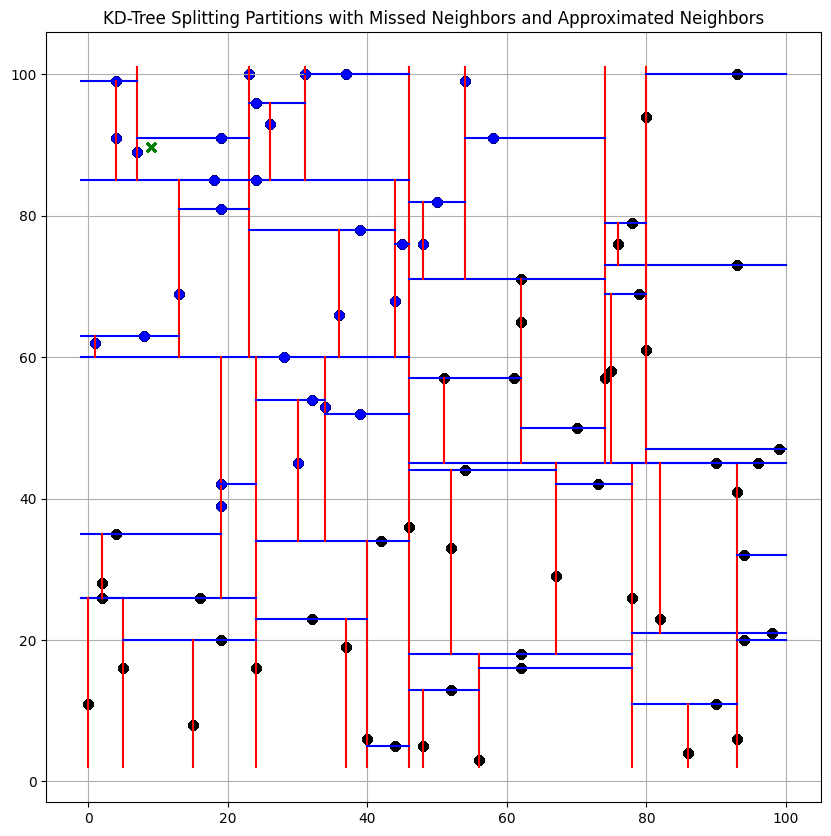

In [102]:
import numpy as np
import matplotlib.pyplot as plt

def generate_dataset(size):
    return np.random.randint(0, 101, size=(size, 2))  # Generating random integers between 0 and 100 for each dimension


# Sample 2D dataset and query point
X = generate_dataset(80)
query_pt = np.random.rand(2) * 100  # Random query point between 0 and 100

# Definition of KD-Tree Node
class KDNode:
    def __init__(self, point, left=None, right=None):
        self.point = point
        self.left = left
        self.right = right

# Function to build KD-Tree
def build_kdtree(points, depth=0):
    n = len(points)
    if n == 0:
        return None

    k = len(points[0])
    axis = depth % k

    sorted_points = sorted(points, key=lambda point: point[axis])
    median_index = n // 2

    return KDNode(
        point=sorted_points[median_index],
        left=build_kdtree(sorted_points[:median_index], depth + 1),
        right=build_kdtree(sorted_points[median_index + 1:], depth + 1)
    )

# Function to plot KD-Tree with neighbors
def plot_kdtree_with_neighbors(node, min_x, max_x, min_y, max_y, query_pt, neighbors, missed_neighbors, depth=0):
    if node is not None:
        k = len(node.point)
        axis = depth % k

        if axis == 0:
            plt.plot([node.point[0], node.point[0]], [min_y, max_y], 'r-')
            plot_kdtree_with_neighbors(node.left, min_x, node.point[0], min_y, max_y, query_pt, neighbors, missed_neighbors, depth + 1)
            plot_kdtree_with_neighbors(node.right, node.point[0], max_x, min_y, max_y, query_pt, neighbors, missed_neighbors, depth + 1)
        else:
            plt.plot([min_x, max_x], [node.point[1], node.point[1]], 'b-')
            plot_kdtree_with_neighbors(node.left, min_x, max_x, min_y, node.point[1], query_pt, neighbors, missed_neighbors, depth + 1)
            plot_kdtree_with_neighbors(node.right, min_x, max_x, node.point[1], max_y, query_pt, neighbors, missed_neighbors, depth + 1)
    
    # Plot points and query point
    plt.scatter(X[:, 0], X[:, 1], c='k', label='Dataset')
    plt.scatter(query_pt[0], query_pt[1], c='g', marker='x', label='Query Point')  # Query point in green

    if neighbors:
        neighbors = np.array(neighbors)  # Convert neighbors list to numpy array
        plt.scatter(neighbors[:, 0], neighbors[:, 1], c='b', marker='o', label='Neighbors Approximated by KD-Tree')  # Neighbors approximated by KD-Tree in blue

    if missed_neighbors:
        missed_x = [neighbor[0] for neighbor in missed_neighbors]
        missed_y = [neighbor[1] for neighbor in missed_neighbors]
        plt.scatter(missed_x, missed_y, c='r', marker='x', label='Missed Neighbors')  # Missed neighbors in red with 'x' marker

    plt.grid(True)
    plt.title('KD-Tree Splitting Partitions with Missed Neighbors and Approximated Neighbors')
    # plt.legend()

# Build KD-Tree
kd_tree = build_kdtree(X)

K=30

# Calculate neighbors using KD-Tree
neighbors = train_test_kd(X, np.array([query_pt]), K)
actual_neighbors = test_naive(X, query_pt, K)

actual_neighbors_set = {tuple(x[0]) for x in actual_neighbors}
kd_neighbors_set = {tuple(x) for x in neighbors}
missed_neighbors = actual_neighbors_set - kd_neighbors_set


print(actual_neighbors_set)
print(kd_neighbors_set)
print(f'Missed Neighbors: {missed_neighbors}')
print(neighbors)

# Plot KD-Tree with neighbors
plt.figure(figsize=(10, 10))
plot_kdtree_with_neighbors(kd_tree, min(X[:, 0])-1, max(X[:, 0])+1, min(X[:, 1])-1, max(X[:, 1])+1, query_pt, neighbors, missed_neighbors)
plt.show()


{(7, 89), (4, 91), (19, 91)}
{(4, 99), (7, 89), (4, 91)}
Missed Neighbors: {(19, 91)}
[array([ 7, 89]), array([ 4, 91]), array([ 4, 99])]


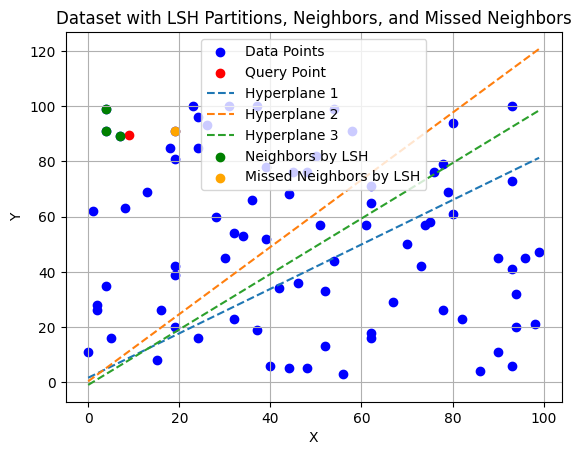

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot dataset with LSH partitions, LSH neighbors, and missed neighbors
def plot_dataset_with_lsh(X, query_pt, X_proj, query_pt_proj, R, lsh_neighbors, missed_neighbors):
    plt.scatter(X[:, 0], X[:, 1], color='blue', label='Data Points')
    plt.scatter(query_pt[0], query_pt[1], color='red', label='Query Point')

    for i in range(R.shape[1]):
        x1 = np.array([min(X[:, 0]), max(X[:, 0])])
        x2 = (-R[0, i] - R[1, i]*x1) / R[2, i]
        plt.plot(x1, x2, linestyle='--', label=f'Hyperplane {i+1}')

    lsh_neighbors = np.array(lsh_neighbors)  # Convert to numpy array
    plt.scatter(lsh_neighbors[:, 0], lsh_neighbors[:, 1], color='green', label='Neighbors by LSH')

    missed_neighbors = np.array(missed_neighbors)  # Convert to numpy array
    plt.scatter(missed_neighbors[:, 0], missed_neighbors[:, 1], color='orange', label='Missed Neighbors by LSH')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Dataset with LSH Partitions, Neighbors, and Missed Neighbors')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train LSH and find neighbors
P = 3  # Number of projections
# K = 3  # Number of nearest neighbors to find
X_proj, query_pt_proj, R = lsh_train(X, np.array([query_pt]), P, K)
neighbors = lsh_test(X, X_proj, query_pt_proj, K)[0]

actual_neighbors = test_naive(X, query_pt, K)

actual_neighbors_set = {tuple(x[0]) for x in actual_neighbors}
lsh_neighbors_set = {tuple(x) for x in neighbors}

missed_neighbors = actual_neighbors_set - lsh_neighbors_set
print(actual_neighbors_set)
print(lsh_neighbors_set)
print(f'Missed Neighbors: {missed_neighbors}')
print(neighbors)

missed_neighbors = np.array(list(missed_neighbors))  # Convert to numpy array

# Plot dataset with LSH partitions, LSH neighbors, and missed neighbors
plot_dataset_with_lsh(X, query_pt, X_proj, query_pt_proj, R, neighbors, missed_neighbors)
